<a href="https://colab.research.google.com/github/dcheng69/leetcode/blob/master/Copy_of_LSTM_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanAbsoluteError
from google.colab import files
import os

def check_and_reconnect_drive():
    drive_path = './drive/MyDrive/dataset/Weather.csv'
    try:
        # Check if Google Drive is still connected and file exists
        if os.path.exists(drive_path):
            return drive_path
        else:
            raise FileNotFoundError
    except FileNotFoundError:
        # If not, reconnect Google Drive and ask user to upload the file
        drive.mount('/content/drive')
        print("Please upload 'Weather.csv'")
        uploaded = files.upload()
        for filename in uploaded.keys():
            if filename.endswith('.csv'):
                return filename

# Use the function to get the file path
csv_file_path = check_and_reconnect_drive()

# Read the CSV file using pandas
df = pd.read_csv(csv_file_path)
df.head()

Mounted at /content/drive
Please upload 'Weather.csv'


Saving Weather.csv to Weather.csv


,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
# Feature Engineering from dates and times
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)
df['hour'] = df['Formatted Date'].dt.hour
df['day'] = df['Formatted Date'].dt.day
df['month'] = df['Formatted Date'].dt.month
df['year'] = df['Formatted Date'].dt.year
df['day_of_week'] = df['Formatted Date'].dt.dayofweek

# Create cyclical features for time data
df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
df['day_sin'] = np.sin(df['day'] * (2 * np.pi / 30))
df['day_cos'] = np.cos(df['day'] * (2 * np.pi / 30))
df['month_sin'] = np.sin((df['month']-1) * (2 * np.pi / 12))
df['month_cos'] = np.cos((df['month']-1) * (2 * np.pi / 12))
df['day_of_week_sin'] = np.sin(df['day_of_week'] * (2 * np.pi / 7))
df['day_of_week_cos'] = np.cos(df['day_of_week'] * (2 * np.pi / 7))

# Selecting features and target
features = df.drop(['Loud Cover', 'Formatted Date', 'Precip Type', 'Daily Summary'], axis=1)
target = df['Temperature (C)']

# One-hot encoding categorical variables
features = pd.get_dummies(features)

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)


In [ ]:
# Convert data to sequences
time_steps = 80
X_data, y_data = [], []
for i in range(time_steps, len(scaled_features)):
    X_data.append(scaled_features[i-time_steps:i])
    y_data.append(target[i])
X_data, y_data = np.array(X_data), np.array(y_data)

In [ ]:
# Splitting the data into 70% for training and 15% for validation and 15% for testing
train_size = int(0.7 * len(X_data))
val_size = train_size + int(0.15 * len(X_data))# next 15% of data for validation

# Split the data while maintaining the sequence order
X_train = X_data[:train_size]
y_train = y_data[:train_size]
X_val = X_data[train_size:val_size]
y_val = y_data[train_size:val_size]
X_test = X_data[val_size:]
y_test = y_data[val_size:]
#X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

Feature Generating with Layer, Neurons, Learning Rate and Activation Functions.

## 1. Layer and Neuron Configuration
- **Number of Layers**: Start with 2 layers and increase based on model performance and overfitting.
- **Neurons in Each Layer**: Begin with a 30 number of neurons per layer.


Try three layers with 30 neurons, learing rate 0.0001, batch_size:64


In [ ]:
# Define the LSTM model: Three layers with 30 units
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# traning model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/20
1055/1055 [==============================] - 98s 89ms/step - loss: 124.2780 - mean_absolute_error: 8.8276 - val_loss: 66.9990 - val_mean_absolute_error: 6.3036
Epoch 2/20
1055/1055 [==============================] - 90s 85ms/step - loss: 65.4594 - mean_absolute_error: 6.0008 - val_loss: 39.6195 - val_mean_absolute_error: 4.5904
Epoch 3/20
1055/1055 [==============================] - 90s 85ms/step - loss: 42.6578 - mean_absolute_error: 4.6578 - val_loss: 25.9339 - val_mean_absolute_error: 3.6394
Epoch 4/20
1055/1055 [==============================] - 90s 86ms/step - loss: 29.1742 - mean_absolute_error: 3.7600 - val_loss: 17.8846 - val_mean_absolute_error: 2.9835
Epoch 5/20
1055/1055 [==============================] - 90s 86ms/step - loss: 20.2990 - mean_absolute_error: 3.0839 - val_loss: 13.4134 - val_mean_absolute_error: 2.6387
Epoch 6/20
1055/1055 [==============================] - 91s 86ms/step - loss: 14.3303 - mean_absolute_error: 2.5771 - val_loss: 9.0083 - val_mean_abs

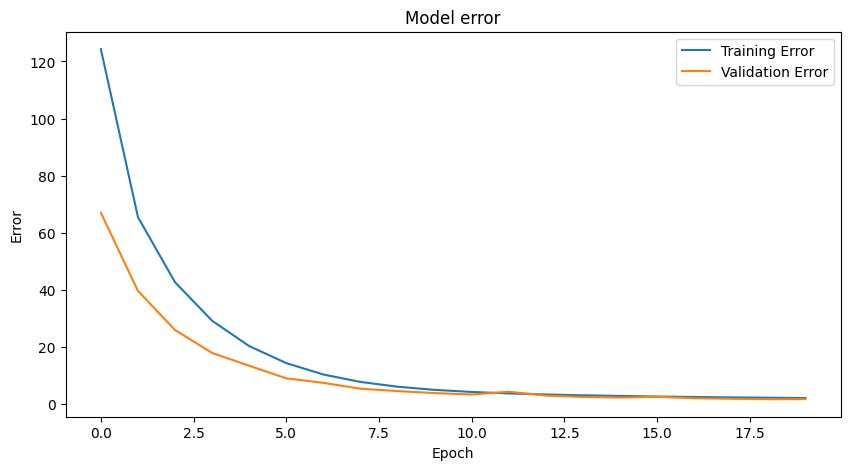

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result returned by the 'model.fit()' call

# Plot training & validation error values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


Calculate R2 Score

453/453 [==============================] - 3s 6ms/step
R-squared for Training Set: 0.9834934758100159
R-squared for Validation Set: 0.982446197147598


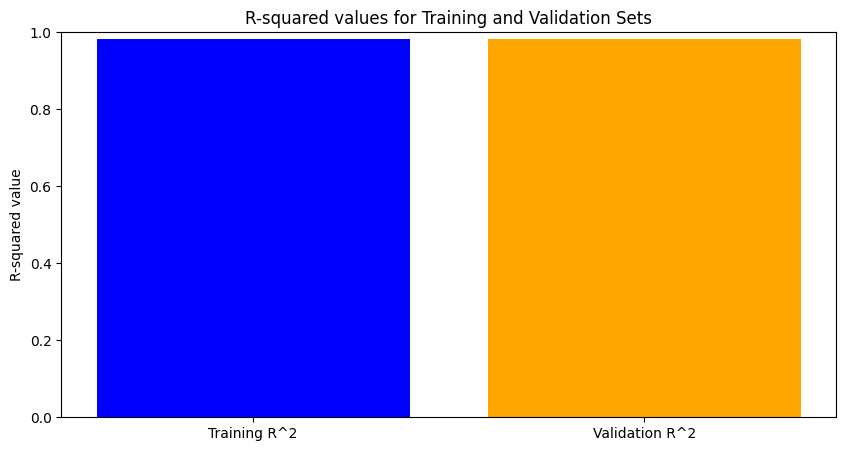

In [ ]:
from sklearn.metrics import r2_score

# Predict the values using the trained model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate R-squared value for training and validation sets
r_squared_train = r2_score(y_train, y_train_pred)
r_squared_val = r2_score(y_val, y_val_pred)

print(f'R-squared for Training Set: {r_squared_train}')
print(f'R-squared for Validation Set: {r_squared_val}')

# Plotting R-squared values
plt.figure(figsize=(10, 5))
plt.bar(['Training R^2', 'Validation R^2'], [r_squared_train, r_squared_val], color=['blue', 'orange'])
plt.title('R-squared values for Training and Validation Sets')
plt.ylabel('R-squared value')
plt.ylim(0, 1)  # R-squared value range from 0 to 1
plt.show()


2. Try three layers with 50 neurons, learing rate 0.01, batch_size:128, Dropout(0.01), activation='tanh'

---
正则化过度？


In [ ]:
from tensorflow.keras.optimizers import SGD

# Define the LSTM model with three layers and a dropout rate of 0.1
model = Sequential()
model.add(LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.001))  # Adding dropout for regularization
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.001))  # Adding dropout for regularization
model.add(LSTM(units=20))
model.add(Dropout(0.001))  # Adding dropout for regularization
model.add(Dense(units=1))

# Use SGD optimizer instead of Adam, set appropriate learning rate and momentum
optimizer = SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# traning model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

Epoch 1/30
528/528 [==============================] - 21s 29ms/step - loss: 34.7090 - mean_absolute_error: 3.8624 - val_loss: 2.6928 - val_mean_absolute_error: 1.3046
Epoch 2/30
528/528 [==============================] - 12s 24ms/step - loss: 2.6720 - mean_absolute_error: 1.1591 - val_loss: 1.4589 - val_mean_absolute_error: 0.8536
Epoch 3/30
528/528 [==============================] - 12s 23ms/step - loss: 2.2369 - mean_absolute_error: 1.0387 - val_loss: 1.4996 - val_mean_absolute_error: 0.8677
Epoch 4/30
528/528 [==============================] - 14s 27ms/step - loss: 2.0267 - mean_absolute_error: 0.9664 - val_loss: 1.3240 - val_mean_absolute_error: 0.7765
Epoch 5/30
528/528 [==============================] - 14s 26ms/step - loss: 2.0138 - mean_absolute_error: 0.9651 - val_loss: 1.1941 - val_mean_absolute_error: 0.7331
Epoch 6/30
528/528 [==============================] - 12s 24ms/step - loss: 1.9060 - mean_absolute_error: 0.9310 - val_loss: 1.6066 - val_mean_absolute_error: 0.9180
Epo

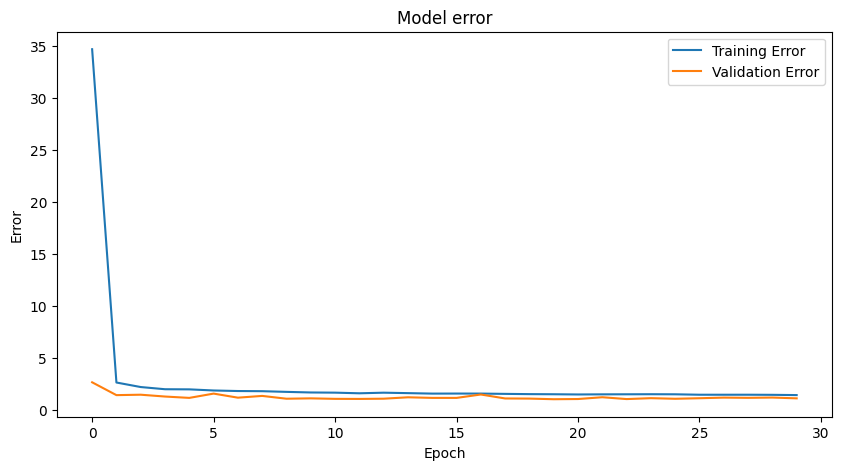

In [ ]:
# Plot training & validation error values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

453/453 [==============================] - 2s 5ms/step
RMSE for Training Set: 1.217330021820169
RMSE for Validation Set: 1.0727384364404957


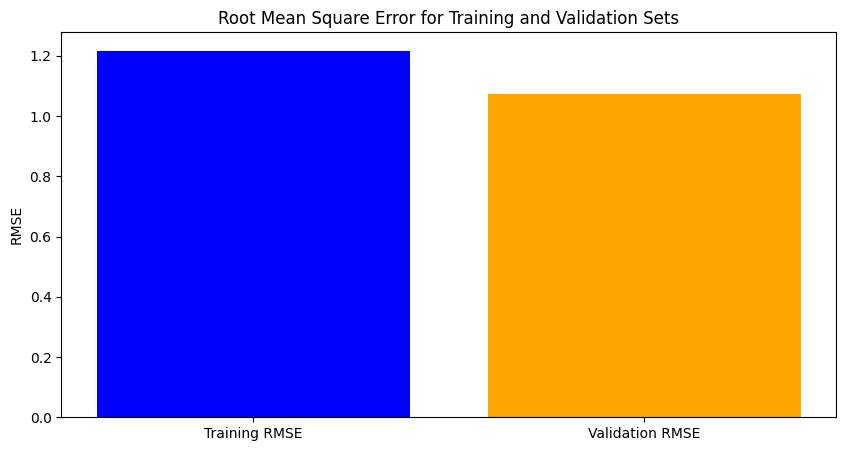

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Predict the outputs with the model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))

print(f'RMSE for Training Set: {rmse_train}')
print(f'RMSE for Validation Set: {rmse_val}')

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.bar(['Training RMSE', 'Validation RMSE'], [rmse_train, rmse_val], color=['blue', 'orange'])
plt.title('Root Mean Square Error for Training and Validation Sets')
plt.ylabel('RMSE')
plt.show()


3. Try three layers with 100 neurons, learing rate 0.01, batch_size:128, activation='tanh', Dropout(0.001)


---
从您提供的RMSE（均方根误差）值来看，模型在训练集和验证集上的性能相当接近，这是一个良好的迹象，说明模型没有在训练集上过度拟合。两者之间的差距很小，训练误差略低于验证误差，这是典型的预期结果，因为模型直接在训练数据上学习。


---




In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
model.add(Dropout(0.05))
model.add(LSTM(units=50, return_sequences=True, activation='tanh'))  # The second LSTM layer should not return sequences as it is the last LSTM layer before the Dense output layer
model.add(Dropout(0.05))
model.add(LSTM(units=50))  # The last LSTM layer should not return sequences
model.add(Dropout(0.05))
model.add(Dense(units=1, activation='linear'))  # Output layer



# Use SGD optimizer instead of Adam, set appropriate learning rate and momentum
optimizer = SGD(learning_rate=0.01, momentum=0.9)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# traning model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/30
528/528 [==============================] - 29s 45ms/step - loss: 18.8673 - mean_absolute_error: 2.7813 - val_loss: 2.3888 - val_mean_absolute_error: 1.1914
Epoch 2/30
528/528 [==============================] - 23s 44ms/step - loss: 3.2139 - mean_absolute_error: 1.3111 - val_loss: 1.9066 - val_mean_absolute_error: 0.9837
Epoch 3/30
528/528 [==============================] - 21s 40ms/step - loss: 2.7197 - mean_absolute_error: 1.1817 - val_loss: 1.5379 - val_mean_absolute_error: 0.8815
Epoch 4/30
528/528 [==============================] - 21s 40ms/step - loss: 2.5794 - mean_absolute_error: 1.1469 - val_loss: 1.5281 - val_mean_absolute_error: 0.8881
Epoch 5/30
528/528 [==============================] - 23s 44ms/step - loss: 2.3763 - mean_absolute_error: 1.0900 - val_loss: 1.3737 - val_mean_absolute_error: 0.8229
Epoch 6/30
528/528 [==============================] - 23s 43ms/step - loss: 2.3060 - mean_absolute_error: 1.0682 - val_loss: 1.4193 - val_mean_absolute_error: 0.8101
Epo

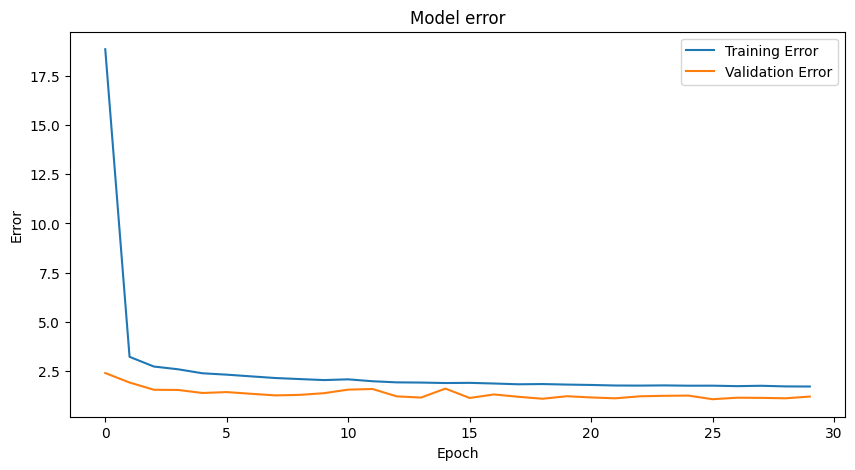

In [ ]:
# Plot training & validation error values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

The third one This looks good


453/453 [==============================] - 5s 12ms/step
RMSE for Training Set: 1.20791279507666
RMSE for Validation Set: 1.0916873413466381


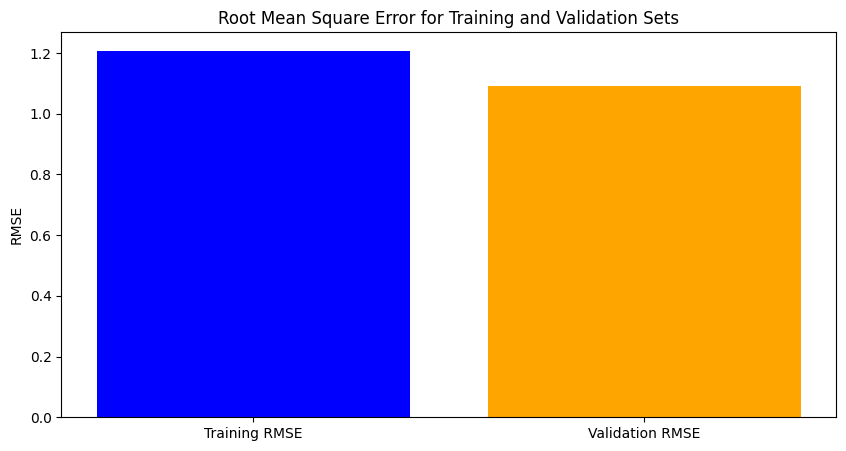

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Predict the outputs with the model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))

print(f'RMSE for Training Set: {rmse_train}')
print(f'RMSE for Validation Set: {rmse_val}')

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.bar(['Training RMSE', 'Validation RMSE'], [rmse_train, rmse_val], color=['blue', 'orange'])
plt.title('Root Mean Square Error for Training and Validation Sets')
plt.ylabel('RMSE')
plt.show()




---


Not Good

---



In [ ]:
model = Sequential()
# Using 'relu' activation for hidden layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dropout(0.2))#for the first layer
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=50))  # The last LSTM layer should not return sequences
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='linear'))

optimizer = Adam(learning_rate=0.003)

model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[MeanAbsoluteError()])

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# traning model
history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)


Epoch 1/30
603/603 [==============================] - 12s 17ms/step - loss: 30.9031 - mean_absolute_error: 3.7266 - val_loss: 6.8867 - val_mean_absolute_error: 1.9700
Epoch 2/30
603/603 [==============================] - 10s 16ms/step - loss: 8.9412 - mean_absolute_error: 2.2511 - val_loss: 4.5909 - val_mean_absolute_error: 1.5521
Epoch 3/30
603/603 [==============================] - 9s 15ms/step - loss: 7.7767 - mean_absolute_error: 2.0873 - val_loss: 4.5745 - val_mean_absolute_error: 1.5609
Epoch 4/30
603/603 [==============================] - 12s 19ms/step - loss: 6.8038 - mean_absolute_error: 1.9340 - val_loss: 3.1788 - val_mean_absolute_error: 1.2676
Epoch 5/30
603/603 [==============================] - 10s 16ms/step - loss: 6.2303 - mean_absolute_error: 1.8427 - val_loss: 2.8312 - val_mean_absolute_error: 1.1994
Epoch 6/30
603/603 [==============================] - 9s 16ms/step - loss: 5.7990 - mean_absolute_error: 1.7730 - val_loss: 2.5054 - val_mean_absolute_error: 1.1039
Epoch

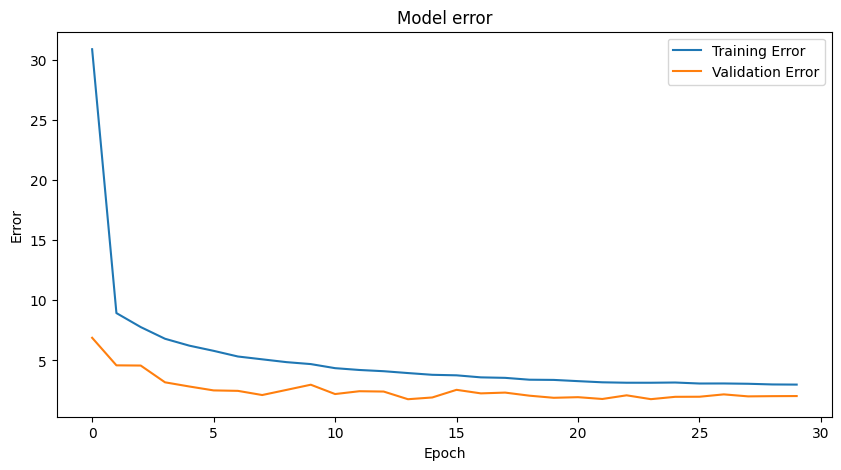

In [ ]:
# Plot training & validation error values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Error')
plt.plot(history.history['val_loss'], label='Validation Error')
plt.title('Model error')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


603/603 [==============================] - 2s 3ms/step
RMSE for Training Set: 1.4098037849040064
RMSE for Validation Set: 1.4266568459472069


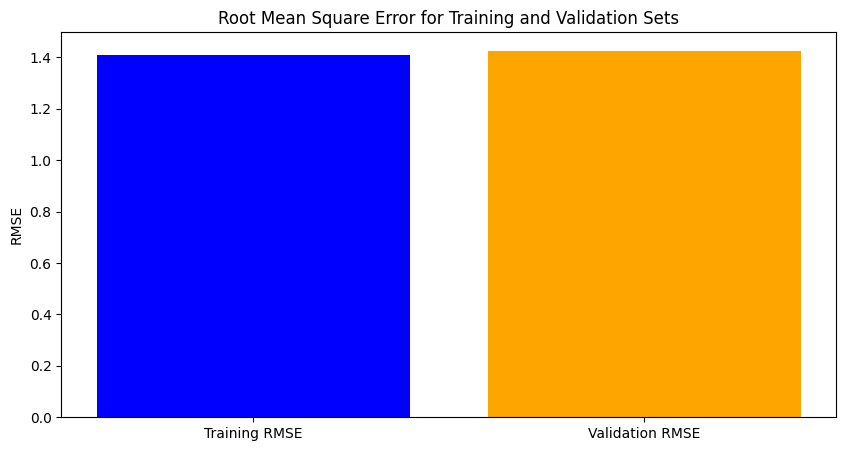

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Predict the outputs with the model
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate RMSE for training and validation sets
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))

print(f'RMSE for Training Set: {rmse_train}')
print(f'RMSE for Validation Set: {rmse_val}')

# Plot the RMSE values
plt.figure(figsize=(10, 5))
plt.bar(['Training RMSE', 'Validation RMSE'], [rmse_train, rmse_val], color=['blue', 'orange'])
plt.title('Root Mean Square Error for Training and Validation Sets')
plt.ylabel('RMSE')
plt.show()


## 3. Add Activation Functions
- **Common Choices**: ReLU for hidden layers, Sigmoid/Tanh for output layers in binary classification tasks.
- **Experiment**: Different activation functions can be tried and evaluated.


Evaluate Model: After tuning and training, evaluate the final model on the test set (X_test, y_test)